# Demo 4 : Examine the Missing Values

# Exercise: Titanic Dataset - Find and Visualize Missing Data

It is quite common for datasets to have data missing, which can cause problems when we perform machine learning. Missing data can be hard to spot at a first glance.

Recall our scenario - we have obtained a list of passengers on the Titanic's failed maiden voyage and would like to try to figure out which kinds of things predicted whether a passenger would survive. Our first task, which we will perform here, is to check whether our dataset has missing information.

## Preparing data

Let's use Pandas to load the dataset and take a cursory look at it:

In [1]:
import pandas as pd

# Load data from our dataset file into a pandas dataframe
dataset = pd.read_csv('titanic.csv', index_col=False, sep=",", header=0)

# Let's take a look at the data
dataset.head()


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


And now a quick peek at how many samples and columns we have:



In [2]:
# Shape tells us how many rows and columns we have
print(dataset.shape)

(891, 12)


We have data for 891 passengers, each described by 12 different variables.

## Finding Missing Data

Do we have a complete dataset?

No. We know from history that there were more than 2000 people on the Titanic, so we know straight away that we are missing information on more than 1000 people! 

How can we tell whether what's left is complete?

We could print the entire dataset, but this would be prone to human error and impractical with this many samples.

A better options is to use `pandas` to report columns that have "empty" cells:

In [ ]:
# Calculate the number of empty cells in each column
# The following line consists of three commands. Try
# to think about how they work together to calculate
# the number of missing entries per column
missing_data = dataset.isnull().sum().to_frame()

# Rename column holding the sums
missing_data = missing_data.rename(columns={0:'Empty Cells'})

# Print the results
print(missing_data)

It looks like we don't know the age of 177 passengers, nor whether 2 of them even embarked.

Cabin information for a whopping 687 persons is also missing.

## Missing Data Visualizations

Sometimes it can be helpful to visualise whether missing data form some kind of pattern.   

There's a few ways we can plot the absence of data. One of the most helpful is to literally plot gaps in the dataset:

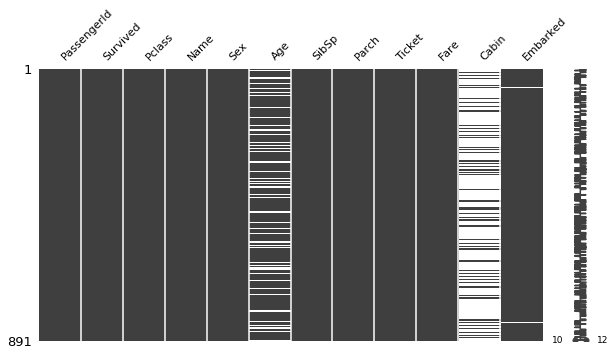

In [3]:
# import missingno package
import missingno as msno

# Plot a matrix chart, set chart and font size
msno.matrix(dataset, figsize=(10,5), fontsize=11)

The white bars in the graph show where data are missing. Here, the patterns are not clear visually, but it could it be that many passengers missing `Age` information are also missing `Cabin` information?

## Identifying Individual Passengers with Missing Information.

Let's use pandas to get a list of passengers whose age we don't know:

In [ ]:
# Select Passengers with unknown age
# Notice how we use .isnull() rows with no value
unknown_age = dataset[dataset["Age"].isnull()]

# Print only the colums we want for the moment (to better fit the screen)
# limit output to 20 rows
unknown_age[["PassengerId","Name", "Survived", "Age"]][:20]

This technique can be used to list the passengers with missing `Cabin` or `Embarked` information as well. Let's combine these using a `AND` to see how many passengers are missing both Cabin and Age information


In [ ]:
# Find those missing age or cabin information
missing_age = dataset["Age"].isnull()
missing_cabin = dataset["Cabin"].isnull()

# Find those missing both
unknown_age_and_cabin = dataset[missing_age & missing_cabin]
print("Number of passengers missing age and cabin information:", len(unknown_age_and_cabin))

Our suspicions were correct - most passengers missing age information are also missing cabin information. 

Normally, from here, we would want to know _why_ we have this issue. A good hypothesis is that information was not collected well for the passengers with the cheap tickets. 

Let's plot a histogram of ticket classes, and another of just people missing information. 

In [ ]:
import graphing

# 'graphing' is custom code we use to make graphs quickly.
# If you would like to read it in detail, it can be found
# in our GitHub repository
graphing.histogram(dataset, 'Pclass', title='Ticket Class (All Passengers)', show=True)
graphing.histogram(unknown_age_and_cabin, 'Pclass', title='Ticket Class (Passengers Missing Cabin and Age Information)')

It seems that those missing information typically were passengers with cheaper tickets. These sorts of biases might cause problems in real-world analyses.

## Missing as Zero

Another issue to watch for is that some datasets may have missing values appearing as zero. While the Titanic dataset does not have this problem, let's see what would have happened had this been the case 


In [ ]:
import numpy as np

# Print out the average age of passengers we have age data for
mean_age = np.mean(dataset.Age)
print("The average age on the ship was", mean_age, "years old")

# Now make another model where missing ages contained a 0
dataset['Age_2'] = dataset['Age'].fillna(0)
mean_age = np.mean(dataset.Age_2)
print("The average age on the ship was", mean_age, "years old")

What has happened here? Our analyses have considered the values of `0` to not be 'missing' but rather to be actual ages.

This goes to show that it can be important to time looking at your raw data before running analyses. Another fast way to get a feel for a dataset is to graph how it is distributed:

In [ ]:
graphing.histogram(dataset, label_x="Age_2")

In this case, we notice an unlikely number of very young children. This would be cause for futher inspection of the data, and hopefully help us spot that the missing ages appear as zeros.

## Handling Missing Data

There are many ways to address missing data, each with pros and cons.

Let's take a look at the less complicated options:

### Option 1: Delete data with missing rows

When we have a model that cannot handle missing data, the most prudent thing to do is to remove rows that have information missing.

Let's remove some data from the `Embarked` column, which only has two rows with missing data.

In [ ]:
# Create a "clean" dataset where we cumulatively fix missing values
# Start by removing rows ONLY where "Embarked" has no values
print(f"The original size of our dataset was", dataset.shape)
clean_dataset = dataset.dropna(subset=["Embarked"])
clean_dataset = clean_dataset.reindex()

# How many rows do we have now?
print("The shape for the clean dataset is", clean_dataset.shape)

We can see that the offending two rows are not present in our new clean dataset.

### Option 2: Replace empty values with the mean or median for that data.

In some circumstances, our model cannot handle missing values, and we also cannot afford to remove too much data. If this is the case, sometimes we can fill missing data with the average of the rest of the dataset. Note that imputing data like this can sometimes negatively affect model performance. Usually it is better to simply remove data that are missing, or to use a model that is designed to handle missing values.

Below, we impute data for the `Age` field. We use the mean `Age` from the remaining rows, given that >80% of these are not empty:

In [ ]:
# Calculate the mean value for the Age column
mean_age = clean_dataset["Age"].mean()

print("The mean age is", mean_age)

# Replace empty values in "Age" with the mean calculated above
clean_dataset["Age"].fillna(mean_age, inplace=True)

# Let's see what the clean dataset looks like now
print(clean_dataset.isnull().sum().to_frame().rename(columns={0:'Empty Cells'}))

As you can see above, the `Age` field has no empty cells anymore.

### Option 3: Assign a new category to unknown categorical data

The `Cabin` field is a categorical field because there's a finite number of possible options for cabins in the Titanic. Unfortunately, many records have no cabin listed.

For this exercise it makes perfect sense to create an `Unknown` category and assign it to the cases where the cabin is unknown:

In [ ]:
# Assign unknow to records where "Cabin" is empty
clean_dataset["Cabin"].fillna("Unknown", inplace=True)

# Let's see what the clean dataset looks like now
print(clean_dataset.isnull().sum().to_frame().rename(columns={0:'Empty Cells'}))

That's it! No more missing data!

We only lost two records (where `Embarked` was empty).

That said, we had to make some approximations to fill the missing gaps for the `Age` and `Cabin` columns, and those will certainly influence the performance of any model we train on this data.

## Summary

Missing values can adversely affect the way a Machine Learning model works, so it is important to quickly verify if there are gaps in the data and where they are located.

You are now able to get a "big picture" of what is missing, by using lists and charts, and also to select only the specific items that need to be addressed.

In this exercise, we practiced:

- Finding and visualizing missing values in a dataset using the `pandas` and `missingno` packages.
- Checking whether a dataset uses the value 0 to represent missing values.
- Dealing with missing data in three ways: removing the rows containing missing values, replacing the missing values with the mean or median of that particular feature, and creating a new `Unknown` category if dealing with categorical data.